# Subbundles Part 6: Visualization

**Subbundle** - a subgroup of streamlines with a set of common properties

In [1]:
from utils import get_tractogram_filename, get_scalar_filename

import os.path as op

import tempfile
import numpy as np

import nibabel as nib

from dipy.io.streamline import load_tractogram
from dipy.io.stateful_tractogram import StatefulTractogram
from dipy.stats.analysis import afq_profile, gaussian_weights

from sklearn.metrics.cluster import adjusted_rand_score

import seaborn as sns
import matplotlib.pyplot as plt
from dipy.viz import window, actor
from IPython.display import Image

from AFQ import api
import AFQ.data as afd

from AFQ.viz.fury_backend import visualize_volume
from AFQ.viz.fury_backend import visualize_bundles

/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Streamlines (from Part 2)

In [2]:
myafq = api.AFQ(
    bids_path=op.join(afd.afq_home, 'stanford_hardi'),
    dmriprep='vistasoft'
)

row = myafq.data_frame.iloc[0]

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [3]:
bundle_name='SLF_L'
tg_fname = tg_fname = get_tractogram_filename(myafq, bundle_name)
tractogram = load_tractogram(tg_fname, 'same')
streamlines = tractogram.streamlines
affine = tractogram.affine

## Clusters (from Part 5)

In [4]:
adjacencies_names = ['fa', 'r2', 'md', 'wt', 'mdf']
model_names = ['gmm', 'ms', 'hier']

idxs = []
labels = []

for adjacency_name in adjacencies_names:
    for model_name in model_names:
        label = f'{model_name}_{adjacency_name}'
        labels.append(label)
        idx = np.load(f'{label}_idx.npy')
        idxs.append(idx)

#### Label Switching

Change order of clusters from largest to smallest

In [25]:
def resort_cluster_ids(idx):
    from_values = np.flip(np.argsort(np.bincount(idx))[-(np.unique(idx).size):])
    to_values = np.arange(from_values.size)
    d = dict(zip(from_values, to_values))
    new_idx = np.copy(idx)
    for k, v in d.items(): new_idx[idx==k] = v
    return new_idx        
        
resorted_idxs = []

for idx in idxs:
    resorted_idxs.append(resort_cluster_ids(idx))
    
idxs = resorted_idxs

#### Group Clustered Streamline Indicies

In [26]:
cluster_ids = []
clusters = []

for idx, label in zip(idxs, labels):
    cluster_id = np.unique(idx)
    cluster_ids.append(cluster_id)
    # per cluster streamline indicies
    cluster = np.array([np.where(idx == i)[0] for i in cluster_id])
    clusters.append(cluster)
    print(f"{label} streamlines per cluster:", np.bincount(idx))

gmm_fa streamlines per cluster: [213 170  82]
ms_fa streamlines per cluster: [385  80]
hier_fa streamlines per cluster: [355  57  53]
gmm_r2 streamlines per cluster: [186 166 113]
ms_r2 streamlines per cluster: [372  93]
hier_r2 streamlines per cluster: [314 114  37]
gmm_md streamlines per cluster: [206 161  98]
ms_md streamlines per cluster: [455   5   3   1   1]
hier_md streamlines per cluster: [286 175   4]
gmm_wt streamlines per cluster: [244 142  79]
ms_wt streamlines per cluster: [316 141   6   1   1]
hier_wt streamlines per cluster: [338 124   3]
gmm_mdf streamlines per cluster: [177 144 144]
ms_mdf streamlines per cluster: [382  83]
hier_mdf streamlines per cluster: [333 116  16]


#### External Evaluation: ARI

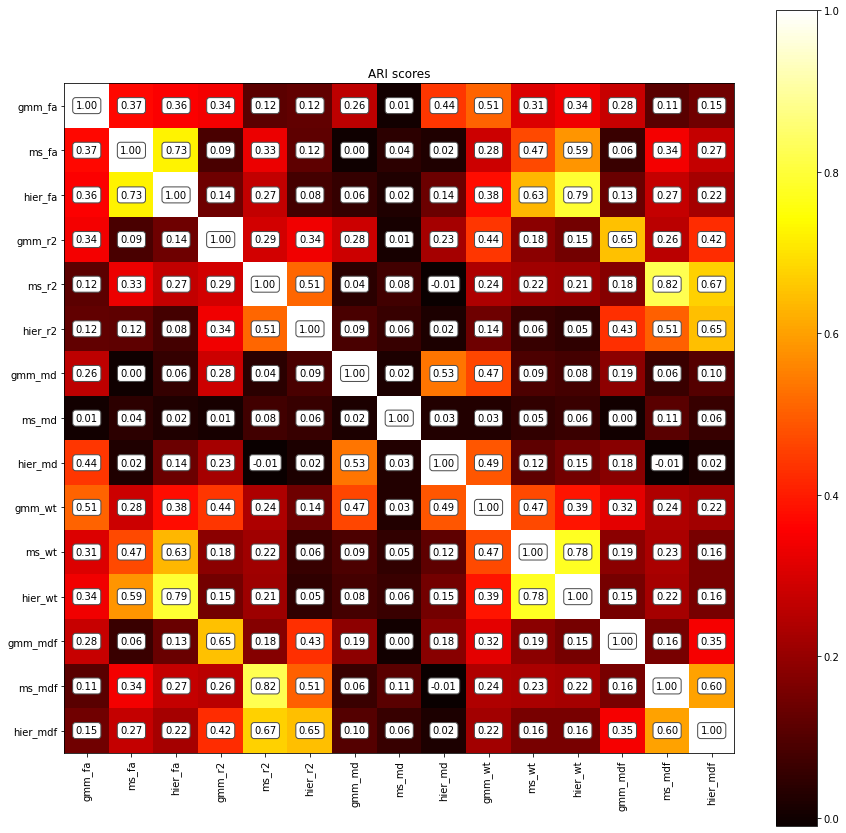

In [6]:
ARI_scores = [[adjusted_rand_score(a,b) for a in idxs] for b in idxs]

plt.figure(figsize = (15,15))
plt.title('ARI scores')
plt.imshow(ARI_scores, cmap='hot', interpolation='nearest')
for (i, j), z in np.ndenumerate(ARI_scores):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.colorbar()
plt.xticks(np.arange(15), labels, rotation=90)
plt.yticks(np.arange(15), labels)
plt.show()

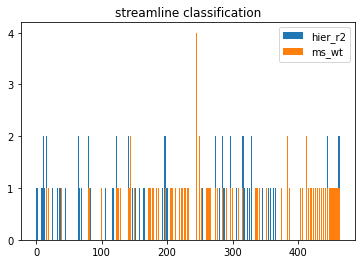

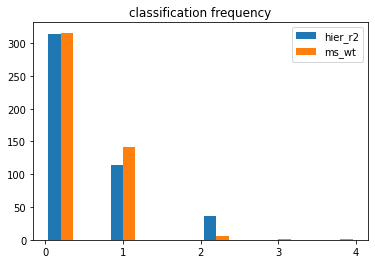

In [7]:
i = 5
j = 10

plt.figure()
plt.title('streamline classification')
plt.bar(np.arange(len(idxs[i])),idxs[i])
plt.bar(np.arange(len(idxs[j])),idxs[j])
plt.legend([labels[i], labels[j]])
plt.yticks(np.arange(np.maximum(np.max(idxs[i]),np.max(idxs[j]))+1))
plt.show()

plt.figure()
plt.title('classification frequency')
plt.hist([idxs[i], idxs[j]], label=[labels[i], labels[j]])
plt.legend()
plt.xticks(np.arange(np.maximum(np.max(idxs[i]),np.max(idxs[j]))+1))
plt.show()

## Visualize clustered streamlines

- Are there any anatomically distinct subbundles?

visualize subbundles

<span style="color:blue">**TODO: `streamtube` plots are not anatomically oriented**</span>

<span style="color:blue">**TODO: coordinate `colormap` to make subbundle identification consistent**</span>

visualize subbundles separately

## ALTERNATIVELY: `fury_backend.visualize_bundles`

In [8]:
colors = sns.color_palette("bright6")

visualize all bundles

In [9]:
volume, color_by_volume = myafq._viz_prepare_vols(
    row,
    volume=None,
    xform_volume=False,
    color_by_volume=None,
    xform_color_by_volume=False
)

visualize targeted bundle

visualize subbundles separately

visualize subbundles

<span style="color:blue">**TODO: Color bundles bug in fury `visualize_bundles`.**</span>

<span style="color:blue">**TODO: `azimuth` hides the volume.**</span>

<span style="color:blue">**TODO: add titles.**</span>

INFO:AFQ.viz:Loading Volume...


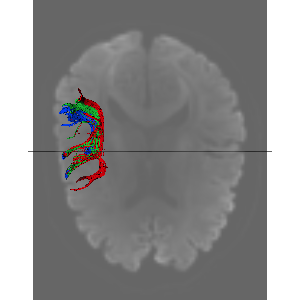

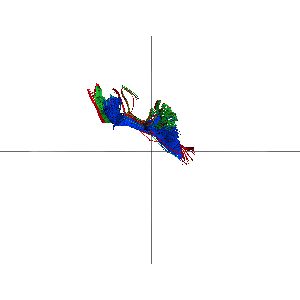

INFO:AFQ.viz:Loading Volume...


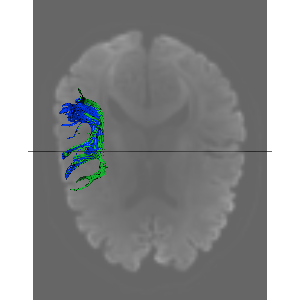

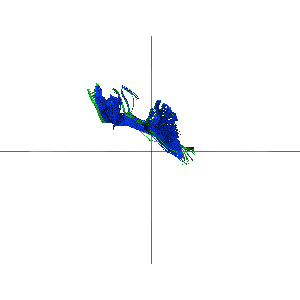

INFO:AFQ.viz:Loading Volume...


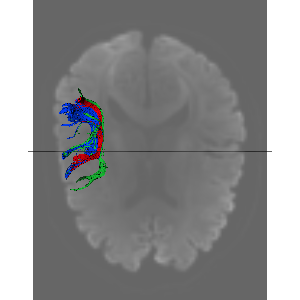

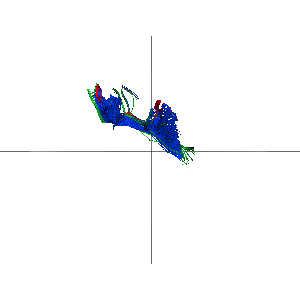

In [15]:
# fa

for ids, idx in zip(cluster_ids[0:3], clusters[0:3]):
    
    figure = visualize_volume(
        volume,
        interact=False,
        inline=False
    )
    
    figure.SetBackground(1,1,1)

    for i in ids:    
        tg = StatefulTractogram.from_sft(streamlines[idx[i]], tractogram)
        tg.to_vox()

        streamline_actor = actor.streamtube(tg.streamlines, colors[i])
        figure.add(streamline_actor)

#     image_actor_z = actor.slicer(volume, opacity=0.6)
#     figure.add(image_actor_z)
    
#   f'{bundle_name} axial'
  
    fname = tempfile.NamedTemporaryFile().name + '.png'
    window.snapshot(figure, fname=fname, size=(300, 300))
    display(Image(fname))
    
#   f'{bundle_name} sagittal'
    figure.azimuth(270)
    figure.roll(270)

#     image_actor_x = image_actor_z.copy()
#     image_actor_x.display(image_actor_x.shape[0]//2, None, None)

#     image_actor_x = image_actor_z.copy()
#     x_midpoint = int(np.round(image_actor_x.shape[0] / 2))
#     image_actor_x.display_extent(x_midpoint,
#                                  x_midpoint, 0,
#                                  image_actor_x.shape[1] - 1,
#                                  0,
#                                  image_actor_x.shape[2] - 1)

#     figure.add(image_actor_x)

    fname = tempfile.NamedTemporaryFile().name + '.png'
    window.snapshot(figure, fname=fname, size=(300, 300))
    display(Image(fname))

<span style="color:blue">**TODO: Currently Debugging.**</span>

### Plot tract profiles for clusters

<span style="color:blue">**TODO: Tract profiles unstable (getting two different results).**</span>

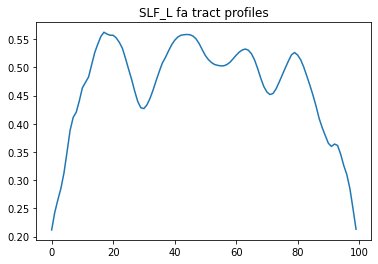

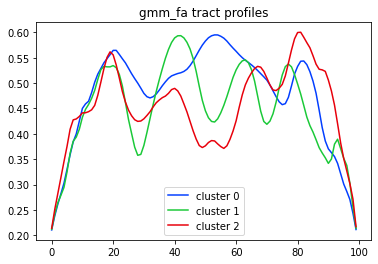

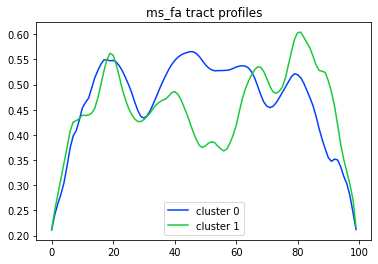

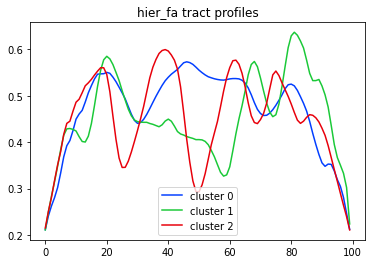

In [13]:
fa_scalar_data = nib.load(get_scalar_filename(myafq, 'DTI_FA')).get_fdata()

plt.figure()
plt.title(f"{bundle_name} fa tract profiles")
plt.plot(afq_profile(
    fa_scalar_data,
    streamlines,
    affine,
    weights=gaussian_weights(streamlines)
))
plt.show()

for name, ids, idx in zip(labels[0:3], cluster_ids[0:3], clusters[0:3]):
    plt.figure()
    plt.title(f"{name} tract profiles")
    for i in ids:
        plt.plot(afq_profile(
            fa_scalar_data,
            streamlines[idx[i]],
            affine,
            weights=gaussian_weights(streamlines[idx[i]])
        ), color=colors[i], label=f"cluster {i}")
    plt.legend()
    plt.show()

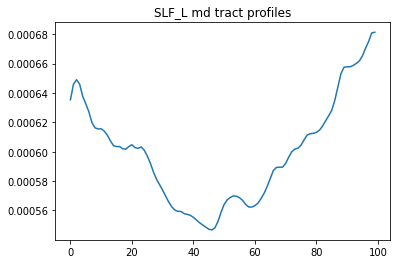

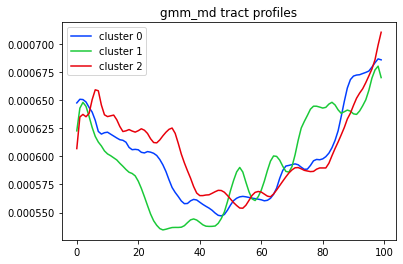

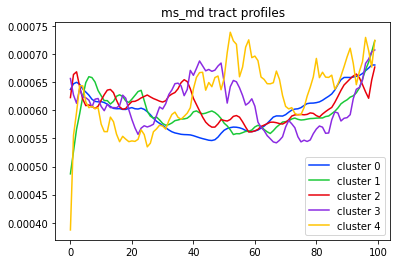

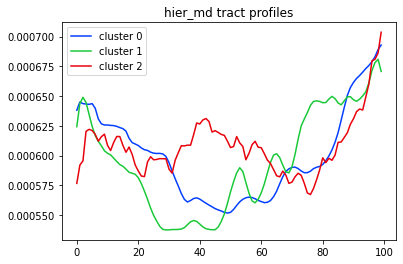

In [14]:
md_scalar_data = nib.load(get_scalar_filename(myafq, 'DTI_MD')).get_fdata()

plt.figure()
plt.title(f"{bundle_name} md tract profiles")
plt.plot(afq_profile(
    md_scalar_data,
    streamlines,
    affine,
    weights=gaussian_weights(streamlines)
))
plt.show()

for name, ids, idx in zip(labels[6:9], cluster_ids[6:9], clusters[6:9]):
    plt.figure()
    plt.title(f"{name} tract profiles")
    for i in ids:
        plt.plot(afq_profile(
            md_scalar_data,
            streamlines[idx[i]],
            affine,
            weights=gaussian_weights(streamlines[idx[i]])
        ), color=colors[i], label=f"cluster {i}")
    plt.legend()
    plt.show()

#### Save individual subbundle tractography files